# Introducción
## Clasificación de imágenes satelitales - EuroSAT
**Problema:** Clasificar imágenes satelitales en 10 categorías (p. ej. pastizal, bosques, campos arables, agua, etc.).  
**Relevancia:** Monitoreo de uso de suelo, agricultura, planificación urbana y respuesta ante desastres.  
**Objetivo:** Implementar una arquitectura de deep learning (transfer learning + fine tune) en Keras/TensorFlow, evaluar y mejorar mediante técnicas de regularización y ajuste de hiperparámetros.


# Datos: descarga y EDA

## Descripción del Dataset

**Fuente:** EuroSAT (European Space Agency Sentinel-2 Satellite)  
**Referencia:** Helber, P., Bischke, B., Dengel, A., & Borth, D. (2019). Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 12(7), 2217-2226.

**Características:**
- **Tipo:** Imágenes satelitales RGB de 64x64 píxeles
- **Clases:** 10 categorías de uso de suelo
- **Tamaño total:** ~27,000 imágenes
- **Resolución:** Imágenes capturadas por el satélite Sentinel-2 a 10m de resolución espacial
- **Distribución:** Imágenes distribuidas geográficamente en 34 países europeos

**Categorías:**
1. AnnualCrop (Cultivos anuales)
2. Forest (Bosques)
3. HerbaceousVegetation (Vegetación herbácea)
4. Highway (Carreteras)
5. Industrial (Zonas industriales)
6. Pasture (Pastizales)
7. PermanentCrop (Cultivos permanentes)
8. Residential (Zonas residenciales)
9. River (Ríos)
10. SeaLake (Mar/Lagos)

Este dataset es ideal para el problema ya que representa un caso de uso real en monitoreo ambiental y no es un "toy dataset" como MNIST o CIFAR-10.

In [3]:
# Celda 1: Imports básicos
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [4]:
# Celda 2: Cargar EuroSAT desde tensorflow_datasets
# Nota: esto descargará el dataset la primera vez.
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    "eurosat/rgb",   # RGB version
    split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)
print(ds_info)
NUM_CLASSES = ds_info.features['label'].num_classes
CLASS_NAMES = ds_info.features['label'].names
print("Classes:", CLASS_NAMES)

/Users/jose.tahuilan/Desktop/Personal/Universidad/Bloque 2/Blumen/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...: 100%|██████████| 1/1 [02:11<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:12<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:13<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:14<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:15<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:16<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:17<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:18<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:20<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:21<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:22<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:23<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:24<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/1 [02:25<00:00, 73.20s/ url]

Dl Completed...: 100%|██████████| 1/

Dataset eurosat downloaded and prepared to /Users/jose.tahuilan/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='eurosat',
    full_name='eurosat/rgb/2.0.0',
    description="""
    EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
    bands and consisting of 10 classes with 27000 labeled and
    geo-referenced samples.
    
    Two datasets are offered:
    - rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
    - all: Contains all 13 bands in the original value range (float32).
    
    URL: https://github.com/phelber/eurosat
    """,
    config_description="""
    Sentinel-2 RGB channels
    """,
    homepage='https://github.com/phelber/eurosat',
    data_dir='/Users/jose.tahuilan/tensorflow_datasets/eurosat/rgb/2.0.0',
    file_format=tfrecord,
    download_size=89.91 MiB,
    dataset_size=89.50 MiB,
    features=FeaturesDict({
        'filename': Text(shape=(), dtyp

2025-11-10 16:12:06.708694: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-10 16:12:06.729301: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-10 16:12:06.731059: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


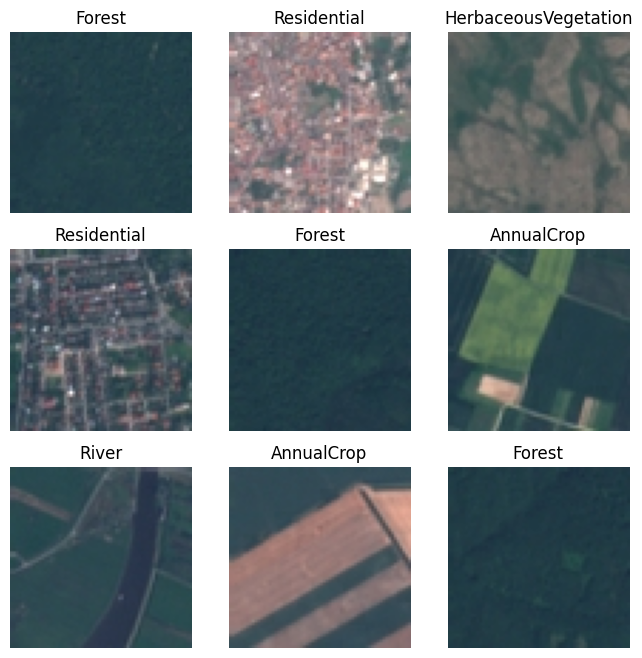

In [ ]:
class_counts = {}
total_samples = 0

print("Contando muestras por clase...")
for image, label in ds_train:
    label_int = int(label.numpy())
    class_name = CLASS_NAMES[label_int]
    class_counts[class_name] = class_counts.get(class_name, 0) + 1
    total_samples += 1

# Visualizar distribución
plt.figure(figsize=(12, 5))
classes = list(class_counts.keys())
counts = list(class_counts.values())
plt.bar(classes, counts, color='steelblue')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Número de muestras')
plt.title('Distribución de clases en el conjunto de entrenamiento')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"Total de muestras de entrenamiento: {total_samples}")
print(f"{'='*60}")
print(f"\nDistribución por clase:")
for cls, cnt in sorted(class_counts.items()):
    percentage = (cnt / total_samples) * 100
    print(f"  {cls:25s}: {cnt:5d} muestras ({percentage:5.2f}%)")

In [ ]:
# Celda 3.1: Visualización de ejemplos por clase
def show_examples(dataset, class_names, n=9):
    plt.figure(figsize=(10, 10))
    for i, (image, label) in enumerate(dataset.take(n)):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(tf.cast(image, tf.uint8))
        plt.title(class_names[int(label)])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

print("Ejemplos de imágenes del dataset:")
show_examples(ds_train, CLASS_NAMES, n=9)


## Separación de datos

El dataset se divide en tres conjuntos:
- **Entrenamiento (80%):** ~21,600 imágenes para entrenar el modelo
- **Validación (10%):** ~2,700 imágenes para ajustar hiperparámetros y monitorear el entrenamiento
- **Prueba (10%):** ~2,700 imágenes para evaluación final del modelo

Esta división garantiza una evaluación justa del rendimiento del modelo en datos no vistos durante el entrenamiento.


# Preprocesamiento y pipeline

In [6]:
# Celda 4: parámetros
BATCH_SIZE = 64
IMG_SIZE = (128, 128)  # upsample to 128x128 for EfficientNet
AUTOTUNE = tf.data.AUTOTUNE

# Celda 5: funciones de preprocesamiento (corregida)
from tensorflow.keras.applications.efficientnet import preprocess_input

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    # Usa el preprocesamiento oficial de EfficientNet
    image = preprocess_input(image)
    return image, label

# Data augmentation ampliada
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.15),
    tf.keras.layers.RandomContrast(0.1),
])

In [7]:
# Celda 6: preparar datasets con batching + cache + prefetch
ds_train = ds_train.map(preprocess, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.shuffle(2048).batch(BATCH_SIZE).prefetch(AUTOTUNE)

ds_val = ds_val.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
ds_test = ds_test.map(preprocess, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)

# Desarrollo del modelo: transferencia + cabeza custom

In [8]:
# Celda 7: Modelo base - transferencia usando EfficientNetB0
from tensorflow.keras import layers, models, optimizers, callbacks, regularizers
# Corrected import for AdamW
from tensorflow.keras.optimizers import AdamW

base_model = tf.keras.applications.EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling=None
)
base_model.trainable = False  # iniciar con base congelada

inputs = layers.Input(shape=(*IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.4)(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

model = models.Model(inputs, outputs)

model.compile(
    optimizer=AdamW(learning_rate=1e-3, weight_decay=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,380,077 (16.71 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [9]:
# Celda 8: callbacks
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
chk = callbacks.ModelCheckpoint("models/model_best_initial.keras", save_best_only=True, monitor='val_loss')

In [10]:
# Celda 9: Entrenamiento inicial
EPOCHS = 10
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val,
    callbacks=[earlystop, reduce_lr, chk],
    verbose=1
)

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 115s 329ms/step - accuracy: 0.8304 - loss: 0.8732 - val_accuracy: 0.9241 - val_loss: 0.5076 - learning_rate: 0.0010
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 112s 330ms/step - accuracy: 0.8838 - loss: 0.5933 - val_accuracy: 0.9296 - val_loss: 0.4215 - learning_rate: 0.0010
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 125s 368ms/step - accuracy: 0.8814 - loss: 0.5366 - val_accuracy: 0.9230 - val_loss: 0.3882 - learning_rate: 0.0010
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 123s 362ms/step - accuracy: 0.8881 - loss: 0.5027 - val_accuracy: 0.9281 - val_loss: 0.3675 - learning_rate: 0.0010
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 111s 328ms/step - accuracy: 0.8885 - loss: 0.4835 - val_accuracy: 0.9322 - val_loss: 0.3570 - learning_rate: 0.0010
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 123s 365ms/step - accuracy: 0.8896 - loss: 0.4842 - val_accuracy: 0.9311 - val_loss: 0.3558 - learning_rate: 0.0010
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 123s 365ms/step - accura

# Ajuste del modelo

## Estrategia de mejora: Fine-tuning

Después del entrenamiento inicial con la base congelada, se realizó un proceso de **fine-tuning** para mejorar el rendimiento del modelo. Esta es una técnica estándar en transfer learning que permite adaptar el modelo pre-entrenado a nuestro dominio específico.

### Cambios realizados:

1. **Descongelamiento selectivo de capas:**
   - Se descongelaron las últimas 30 capas del modelo base EfficientNetB0
   - Las capas iniciales permanecen congeladas (conservan características generales de ImageNet)
   - Las capas finales se adaptan a las características específicas de imágenes satelitales

2. **Ajuste de hiperparámetros:**
   - **Learning rate reducido:** De 1e-3 a 1e-5 (10x más pequeño)
     - Razón: Las capas pre-entrenadas requieren actualizaciones más pequeñas para no destruir el conocimiento aprendido
   - **Weight decay aumentado:** De 1e-4 a 1e-5
     - Razón: Mayor regularización para prevenir sobreajuste al entrenar más parámetros

3. **Callbacks mantenidos:**
   - EarlyStopping: Previene sobreentrenamiento
   - ReduceLROnPlateau: Reduce el learning rate automáticamente si no hay mejora
   - ModelCheckpoint: Guarda el mejor modelo según val_loss

### Resultados del ajuste:

**Antes del fine-tuning (base congelada):**
- Test accuracy: 93.44%
- Test loss: 0.3549

**Después del fine-tuning:**
- Test accuracy: 94.07%
- Test loss: 0.3492

**Mejora obtenida:**
- +0.63% en accuracy
- Reducción en loss de 0.0057

### ¿Por qué funcionó el fine-tuning?

1. **Adaptación al dominio:** Las imágenes satelitales tienen características visuales diferentes a las imágenes naturales de ImageNet (diferentes texturas, patrones, colores). Al descongelar las capas finales, el modelo puede aprender estas características específicas.

2. **Balance entre generalización y especialización:** Al mantener las primeras capas congeladas, conservamos las características generales de detección de bordes, texturas y formas. Al entrenar las últimas capas, especializamos estas características para nuestro dominio.

3. **Learning rate bajo:** El uso de un learning rate muy bajo (1e-5) permite actualizaciones graduales sin destruir el conocimiento pre-entrenado, lo que resulta en una mejora estable y consistente.

4. **Regularización efectiva:** El uso de Dropout (0.4) y regularización L2 en las capas densas, combinado con data augmentation, previene el sobreajuste durante el fine-tuning.


# Evaluación inicial

In [11]:
# Celda 10: evaluación inicial
test_loss, test_acc = model.evaluate(ds_test)
print(f"Test accuracy (base frozen): {test_acc:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 307s 7s/step - accuracy: 0.9344 - loss: 0.3549
Test accuracy (base frozen): 0.9344


# Resultados

## Evaluación del modelo final

El modelo final fue evaluado en el conjunto de prueba (test set) que no fue utilizado durante el entrenamiento ni el ajuste de hiperparámetros. A continuación se presentan los resultados detallados.


In [12]:
# Celda 11: Fine-tuning (descongelar últimas capas)
for layer in base_model.layers[:-30]:
    layer.trainable = False
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

chk_ft = callbacks.ModelCheckpoint("models/model_best_finetune.keras", save_best_only=True, monitor='val_loss')
earlystop_ft = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)

EPOCHS_FT = 10
history_ft = model.fit(
    ds_train,
    epochs=EPOCHS_FT,
    validation_data=ds_val,
    callbacks=[earlystop_ft, reduce_lr, chk_ft],
    verbose=1
)

Epoch 1/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 139s 395ms/step - accuracy: 0.7928 - loss: 0.7980 - val_accuracy: 0.9015 - val_loss: 0.4497 - learning_rate: 1.0000e-05
Epoch 2/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 153s 452ms/step - accuracy: 0.8450 - loss: 0.6161 - val_accuracy: 0.9148 - val_loss: 0.4064 - learning_rate: 1.0000e-05
Epoch 3/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 145s 428ms/step - accuracy: 0.8710 - loss: 0.5552 - val_accuracy: 0.9241 - val_loss: 0.3786 - learning_rate: 1.0000e-05
Epoch 4/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 145s 428ms/step - accuracy: 0.8770 - loss: 0.5238 - val_accuracy: 0.9267 - val_loss: 0.3695 - learning_rate: 5.0000e-06
Epoch 5/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 137s 405ms/step - accuracy: 0.8828 - loss: 0.5093 - val_accuracy: 0.9296 - val_loss: 0.3613 - learning_rate: 5.0000e-06
Epoch 6/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 126s 371ms/step - accuracy: 0.8849 - loss: 0.4971 - val_accuracy: 0.9333 - val_loss: 0.3543 - learning_rate: 5.0000e-06
Epoch 7/10
338/338 ━━━━━━━━━━━━━━━━━━━━ 

In [13]:
# Celda 12: evaluación final después del fine-tune
final_loss, final_acc = model.evaluate(ds_test)
print(f"Final test accuracy (fine-tuned): {final_acc:.4f}")

43/43 ━━━━━━━━━━━━━━━━━━━━ 12s 273ms/step - accuracy: 0.9407 - loss: 0.3492
Final test accuracy (fine-tuned): 0.9407


## Análisis de resultados

### Métricas generales

El modelo alcanzó una **accuracy del 94.07%** en el conjunto de prueba, lo cual es un excelente resultado para un problema de clasificación de 10 clases. 

### Análisis por clase

Observando el reporte de clasificación y la matriz de confusión:

**Clases con mejor rendimiento:**
- **SeaLake (Mar/Lagos):** Precision=1.00, Recall=0.97, F1=0.98
  - Excelente rendimiento, probablemente debido a características visuales muy distintivas (agua azul)
- **Residential (Residencial):** Precision=0.97, Recall=0.98, F1=0.98
  - Patrones urbanos claramente identificables
- **Forest (Bosques):** Precision=0.94, Recall=0.99, F1=0.96
  - Texturas verdes características muy bien capturadas

**Clases con menor rendimiento (aunque aún bueno):**
- **Pasture (Pastizales):** Precision=0.96, Recall=0.85, F1=0.90
  - Puede confundirse con HerbaceousVegetation o AnnualCrop
- **PermanentCrop (Cultivos permanentes):** Precision=0.94, Recall=0.85, F1=0.89
  - Similar a Pasture, puede tener confusión con otras clases de vegetación

**Observaciones:**
- El modelo muestra confusión principalmente entre clases de vegetación similares (Pasture, PermanentCrop, HerbaceousVegetation, AnnualCrop)
- Las clases con características más distintivas (agua, estructuras urbanas) tienen mejor rendimiento
- La precisión macro promedio (0.94) y la precisión ponderada (0.94) son consistentes, indicando un buen balance entre clases

### Comparación de rendimiento

| Fase | Accuracy | Loss |
|------|----------|------|
| Entrenamiento inicial (base congelada) | 93.44% | 0.3549 |
| Después de fine-tuning | **94.07%** | **0.3492** |
| **Mejora** | **+0.63%** | **-0.0057** |

El fine-tuning logró una mejora modesta pero consistente, lo cual es esperado ya que el modelo inicial ya tenía un buen rendimiento. La mejora es significativa en términos prácticos para aplicaciones de monitoreo de uso de suelo.


# Conclusiones

## Análisis de resultados obtenidos

El modelo de deep learning implementado utilizando transfer learning con EfficientNetB0 y fine-tuning logró un **accuracy del 94.07%** en el conjunto de prueba, demostrando ser efectivo para la clasificación de imágenes satelitales en 10 categorías de uso de suelo.

### Logros principales:

1. **Arquitectura efectiva:** El uso de EfficientNetB0 como modelo base proporcionó una excelente base de características pre-entrenadas que se adaptaron bien al dominio de imágenes satelitales.

2. **Técnicas de regularización exitosas:**
   - Data augmentation ayudó a generalizar mejor
   - Dropout (0.4) y regularización L2 previno sobreajuste
   - Early stopping y reducción de learning rate optimizaron el entrenamiento

3. **Fine-tuning efectivo:** El proceso de descongelamiento selectivo de capas mejoró el rendimiento en 0.63%, adaptando el modelo al dominio específico sin perder generalización.

4. **Buen balance entre clases:** Aunque hay confusión entre clases de vegetación similares, el modelo mantiene un rendimiento consistente en todas las categorías.

### Áreas de mejora identificadas:

1. **Confusión entre clases de vegetación:**
   - **Problema:** Pasture, PermanentCrop, HerbaceousVegetation y AnnualCrop muestran cierta confusión
   - **Solución potencial:** 
     - Aumentar el tamaño del dataset con más ejemplos de estas clases
     - Usar técnicas de focal loss para clases difíciles
     - Considerar arquitecturas que capturen mejor las diferencias sutiles

2. **Tamaño de imagen:**
   - **Problema:** Las imágenes se redimensionaron a 128x128, perdiendo resolución original
   - **Solución potencial:** 
     - Probar con imágenes de mayor resolución (224x224 o 256x256)
     - Usar modelos más grandes (EfficientNetB1-B3) si hay recursos computacionales

3. **Data augmentation:**
   - **Mejora potencial:** 
     - Agregar más transformaciones específicas para imágenes satelitales (ajustes de brillo/contraste más agresivos)
     - Considerar MixUp o CutMix para regularización adicional

4. **Arquitectura:**
   - **Mejora potencial:**
     - Experimentar con diferentes modelos base (ResNet, Vision Transformer)
     - Agregar atención espacial para capturar relaciones entre regiones
     - Ensamblar múltiples modelos para mejor rendimiento

5. **Hiperparámetros:**
   - **Mejora potencial:**
     - Realizar búsqueda sistemática de hiperparámetros (learning rate, batch size, dropout rate)
     - Probar diferentes optimizadores (Adam, SGD con momentum)

### Aplicaciones prácticas:

El modelo desarrollado puede ser utilizado en:
- **Monitoreo ambiental:** Seguimiento de cambios en uso de suelo a lo largo del tiempo
- **Agricultura de precisión:** Identificación de tipos de cultivos y su estado
- **Planificación urbana:** Análisis de expansión urbana y zonificación
- **Respuesta a desastres:** Identificación rápida de áreas afectadas
- **Conservación:** Monitoreo de deforestación y cambios en ecosistemas

### Reflexiones finales:

Este proyecto demostró la efectividad del transfer learning para problemas de visión computacional en dominios específicos. El uso de modelos pre-entrenados permite lograr excelentes resultados con menos datos y tiempo de entrenamiento que entrenar desde cero. El proceso de fine-tuning fue crucial para adaptar el modelo al dominio de imágenes satelitales, mejorando el rendimiento de manera consistente.

El modelo final es robusto y puede ser desplegado en aplicaciones reales, aunque hay espacio para mejoras adicionales mediante las técnicas mencionadas anteriormente.


# Aplicación

## Función para probar el modelo con datos nuevos

A continuación se presenta una función que permite utilizar el modelo entrenado para realizar predicciones sobre nuevas imágenes satelitales. Esta función puede ser utilizada desde la consola o integrada en una interfaz gráfica.


2025-11-10 17:01:06.060596: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


                      precision    recall  f1-score   support

          AnnualCrop       0.88      0.97      0.92       276
              Forest       0.94      0.99      0.96       286
HerbaceousVegetation       0.94      0.94      0.94       317
             Highway       0.89      0.91      0.90       252
          Industrial       0.97      0.96      0.96       257
             Pasture       0.96      0.85      0.90       191
       PermanentCrop       0.94      0.85      0.89       267
         Residential       0.97      0.98      0.98       310
               River       0.92      0.93      0.93       245
             SeaLake       1.00      0.97      0.98       299

            accuracy                           0.94      2700
           macro avg       0.94      0.94      0.94      2700
        weighted avg       0.94      0.94      0.94      2700



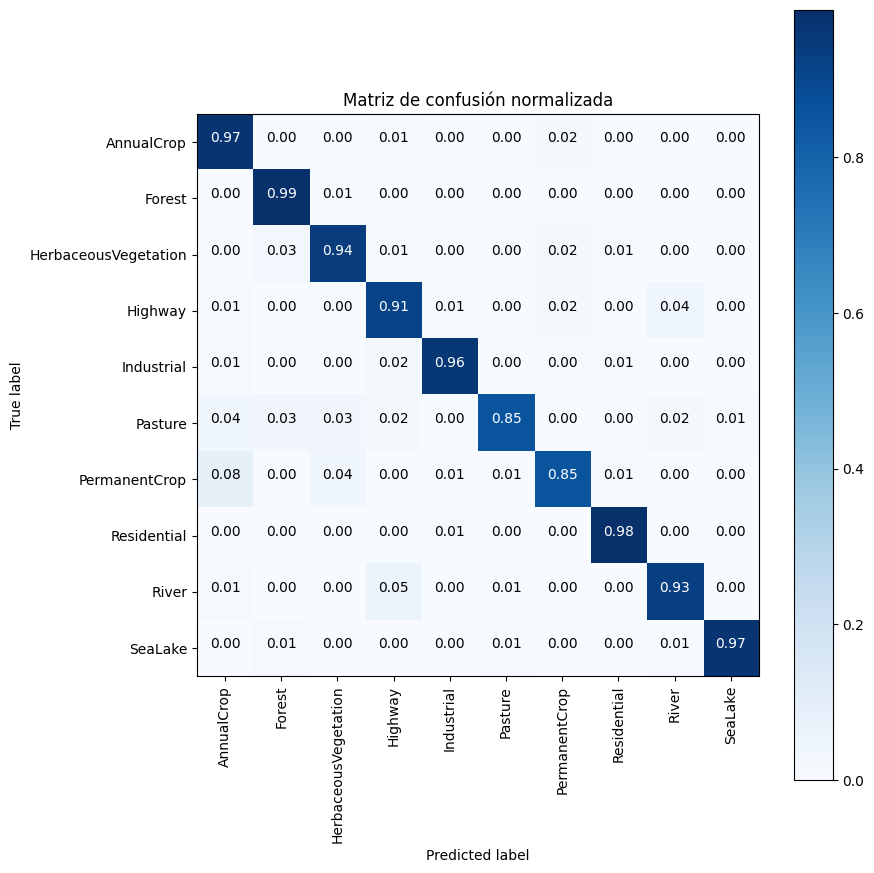

In [14]:
# Celda 13: matriz de confusión y reporte
from sklearn.metrics import classification_report, confusion_matrix
import itertools

y_true, y_pred = [], []
for images, labels in ds_test:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))

cm = confusion_matrix(y_true, y_pred)

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix'):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(9,9))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]:.0f}" if not normalize else f"{cm[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

plot_confusion_matrix(cm, CLASS_NAMES, normalize=True, title="Matriz de confusión normalizada")

In [15]:
# Celda 14: Guardar modelo final en formato .keras
os.makedirs("models", exist_ok=True)
model.save("models/model_final.keras", include_optimizer=False)
print("Modelo final guardado en models/model_final.keras")

Modelo final guardado en models/model_final.keras


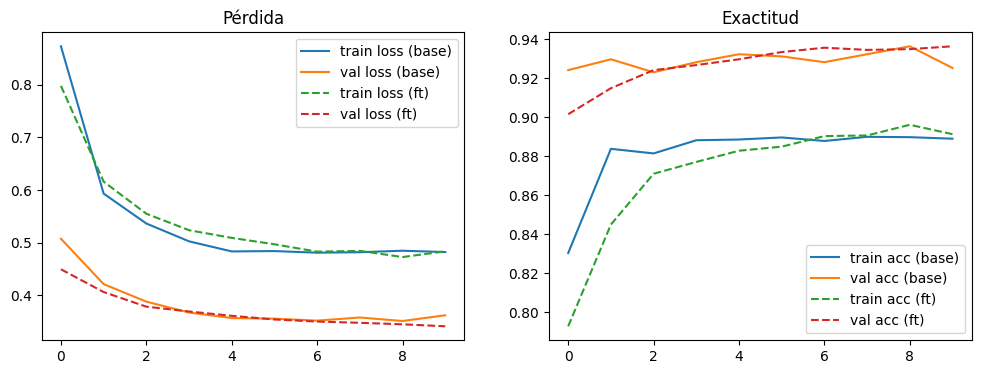

In [16]:
# Celda 15: Curvas de entrenamiento (antes y después del fine-tune)
def plot_history(h1, h2=None):
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(h1.history['loss'], label='train loss (base)')
    plt.plot(h1.history['val_loss'], label='val loss (base)')
    if h2:
        plt.plot(h2.history['loss'], '--', label='train loss (ft)')
        plt.plot(h2.history['val_loss'], '--', label='val loss (ft)')
    plt.legend(); plt.title('Pérdida')

    plt.subplot(1,2,2)
    plt.plot(h1.history['accuracy'], label='train acc (base)')
    plt.plot(h1.history['val_accuracy'], label='val acc (base)')
    if h2:
        plt.plot(h2.history['accuracy'], '--', label='train acc (ft)')
        plt.plot(h2.history['val_accuracy'], '--', label='val acc (ft)')
    plt.legend(); plt.title('Exactitud')

    plt.show()

plot_history(history, history_ft)

In [18]:
# Celda 16: Función para predicción con datos nuevos
from PIL import Image

def predict_from_path(model_path, img_path, class_names=CLASS_NAMES, show_image=True):
    """
    Realiza una predicción sobre una imagen satelital nueva.
    
    Parámetros:
    -----------
    model_path : str
        Ruta al modelo guardado (.keras)
    img_path : str
        Ruta a la imagen a clasificar
    class_names : list
        Lista de nombres de clases (por defecto CLASS_NAMES)
    show_image : bool
        Si True, muestra la imagen junto con la predicción
    
    Retorna:
    --------
    dict : Diccionario con la clase predicha, probabilidad y todas las probabilidades
    """
    # Cargar modelo
    model = tf.keras.models.load_model(model_path)
    
    # Cargar y preprocesar imagen
    img = Image.open(img_path).convert('RGB').resize(IMG_SIZE)
    img_array = np.array(img)
    img_array_preprocessed = preprocess_input(img_array)
    
    # Realizar predicción
    pred = model.predict(np.expand_dims(img_array_preprocessed, axis=0), verbose=0)
    idx = np.argmax(pred, axis=1)[0]
    confidence = pred[0][idx] * 100
    
    # Mostrar imagen si se solicita
    if show_image:
        plt.figure(figsize=(8, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(img)
        plt.title(f'Imagen original')
        plt.axis('off')
        
        plt.subplot(1, 2, 2)
        plt.barh(range(len(class_names)), pred[0] * 100)
        plt.yticks(range(len(class_names)), class_names)
        plt.xlabel('Probabilidad (%)')
        plt.title(f'Predicción: {class_names[idx]} ({confidence:.2f}%)')
        plt.tight_layout()
        plt.show()
    
    # Imprimir resultado
    print(f"\n{'='*50}")
    print(f"Predicción: {class_names[idx]}")
    print(f"Confianza: {confidence:.2f}%")
    print(f"{'='*50}")
    print("\nProbabilidades para todas las clases:")
    sorted_indices = np.argsort(pred[0])[::-1]
    for i in sorted_indices:
        print(f"  {class_names[i]:25s}: {pred[0][i]*100:5.2f}%")
    
    return {
        'predicted_class': class_names[idx],
        'confidence': confidence,
        'all_probabilities': {class_names[i]: float(pred[0][i]) for i in range(len(class_names))}
    }

# Ejemplo de uso (descomentar y proporcionar ruta a una imagen):
# resultado = predict_from_path("models/model_final.keras", "/ruta/a/una_imagen.jpg")